In [ ]:
!ls -a

 .   ..   .config   sample_data  'Untitled Folder'


In [ ]:
%pip install transformers

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
import pandas as pd
data_path = "content/filtered.csv"
try:
    df = pd.read_csv(data_path, engine='python', encoding='utf-8', on_bad_lines='skip')  # or on_bad_lines='warn'
except pd.errors.ParserError as e:
    print(f"Error reading CSV file: {e}")


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [spam for spam in df['spam']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length = 512,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

4153 519 520


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].squeeze(1).to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].squeeze(1).to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} \n| Train Loss: {total_loss_train / len(train_data): .3f} \
                \n| Train Accuracy: {total_acc_train / len(train_data): .3f} \
                \n| Val Loss: {total_loss_val / len(val_data): .3f} \
                \n| Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    predictions = []
    true_labels = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:
              true_labels.extend(test_label.numpy())  # Collect true labels
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].squeeze(1).to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              preds = output.argmax(dim=1).cpu().numpy()  # Get predictions
              predictions.extend(preds)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return predictions, true_labels

In [ ]:
EPOCHS = 1
LR = 1e-6

model = BertClassifier()
print("\n\nTraining...\n\n")
train(model, df_train, df_val, LR, EPOCHS)
print("\n\nTesting...\n\n")
predictions_bert, y_true_bert=evaluate(model, df_test)



Training...




100%|██████████| 2291/2291 [08:13<00:00,  4.65it/s]


Epochs: 1 
| Train Loss:  0.166                 
| Train Accuracy:  0.833                 
| Val Loss:  0.058                 
| Val Accuracy:  0.975


Testing...


Test Accuracy:  0.967


#Naive Bayes

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


In [ ]:
count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(df_train['text'])
X_test = count_vectorizer.transform(df_test['text'])

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, df_train['spam'])  # Adjust 'label' as necessary
predictions_nb = nb_model.predict(X_test)

In [ ]:
y_true = df_test['spam']  # Adjust 'label' as necessary


# Calculate metrics for BERT



In [ ]:
accuracy_bert = accuracy_score(y_true, predictions_bert)
precision_bert = precision_score(y_true, predictions_bert, pos_label=1)  # Adjust as needed
recall_bert = recall_score(y_true, predictions_bert, pos_label=1)  # Adjust as needed
f1_bert = f1_score(y_true, predictions_bert, pos_label=1)  # Adjust as needed


# Calculate metrics for Naive Bayes


In [ ]:
accuracy_nb = accuracy_score(y_true, predictions_nb)
precision_nb = precision_score(y_true, predictions_nb, pos_label=1)  # Adjust as needed
recall_nb = recall_score(y_true, predictions_nb, pos_label=1)  # Adjust as needed
f1_nb = f1_score(y_true, predictions_nb, pos_label=1)  # Adjust as needed


# Compile results


         Model  Accuracy  Precision    Recall  F1 Score
0         BERT  0.966841   0.925197  0.925197  0.925197
1  Naive Bayes  0.989529   0.972656  0.980315  0.976471


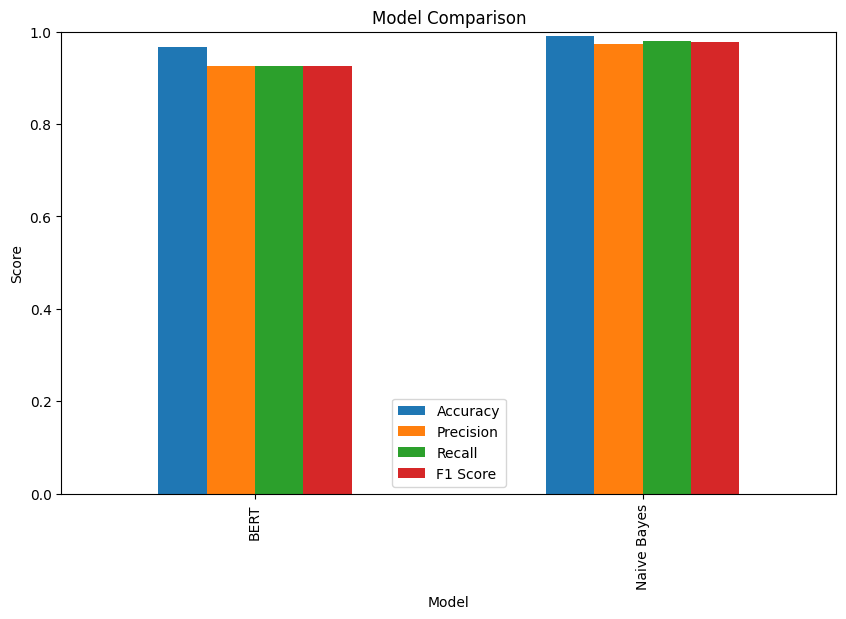

In [ ]:
results = {
    'Model': ['BERT', 'Naive Bayes'],
    'Accuracy': [accuracy_bert, accuracy_nb],
    'Precision': [precision_bert, precision_nb],
    'Recall': [recall_bert, recall_nb],
    'F1 Score': [f1_bert, f1_nb]
}

results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Visualize the results
results_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()
